# Example: Segmentation wwith attention U-net and transfer learning from ImageNet-trained VGG16 model

In [70]:
import os
import numpy as np
from glob import glob
from dotenv import load_dotenv
from pathlib import Path
import matplotlib.pyplot as plt
import Data
from PIL import Image

In [28]:
from tensorflow import keras

This example requires `keras-unet-collection`:
```
pip install keras-unet-collection
```

In [29]:
from keras_unet_collection import models, utils

In [30]:
load_dotenv()
env_path = Path('.')/'.env'
load_dotenv(dotenv_path=env_path)
path = os.getenv('DATA_PATH')
print(path)

C:\Users\pinksterbha\OneDrive - UMCG\Studie\SGGS\data\DataSet


In [33]:
# the indicator of a fresh run
first_time_running = False

(train_names, train_labels), (valid_names, valid_labels), (test_names, test_labels) = Data.load_data_and_split(path)

print("Number of training samples:", len(train_names))
print("Number of validation samples:", len(valid_names))
print("Number of test samples:", len(test_names))

print("Number of training samples:", train_names[8])
print("Number of training samples:", train_labels[8])
print("Number of validation samples:", valid_names[8])
print("Number of validation samples:", valid_labels[8])
print("Number of test samples:", test_names[8])
print("Number of test samples:", test_labels[8])

print(filepath)

Number of training samples: 186
Number of validation samples: 23
Number of test samples: 23
Number of training samples: C:\Users\pinksterbha\OneDrive - UMCG\Studie\SGGS\data\DataSet\images\40-012.jpg
Number of training samples: C:\Users\pinksterbha\OneDrive - UMCG\Studie\SGGS\data\DataSet\l_mask\40-012_L_mask.png
Number of validation samples: C:\Users\pinksterbha\OneDrive - UMCG\Studie\SGGS\data\DataSet\images\43-012.jpg
Number of validation samples: C:\Users\pinksterbha\OneDrive - UMCG\Studie\SGGS\data\DataSet\l_mask\43-012_L_mask.png
Number of test samples: C:\Users\pinksterbha\OneDrive - UMCG\Studie\SGGS\data\DataSet\images\33-015.jpg
Number of test samples: C:\Users\pinksterbha\OneDrive - UMCG\Studie\SGGS\data\DataSet\l_mask\33-015_L_mask.png
C:\Users\pinksterbha\OneDrive - UMCG\Studie\SGGS\data\DataSet/images/


### Exploratory data analysis

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

def ax_decorate_box(ax):
    [j.set_linewidth(0) for j in ax.spines.values()]
    ax.tick_params(axis="both", which="both", bottom=False, top=False, \
               labelbottom=False, left=False, right=False, labelleft=False)
    return ax

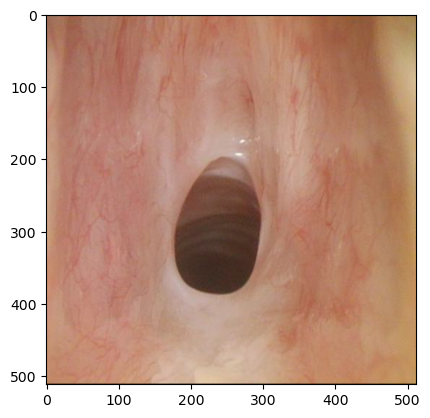

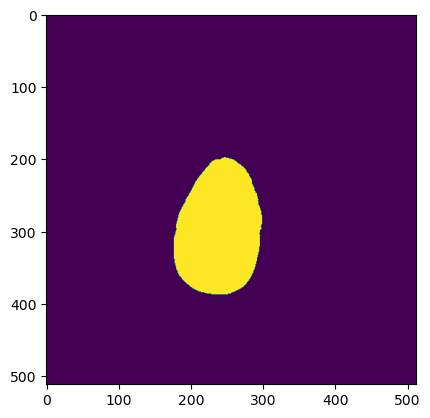

(10, 256, 256, 3)
(10, 256, 256, 3)
[0. 0. 0.]


In [80]:
i_max = 10 # explore 10 images
input_example = utils.image_to_array(train_names[:i_max], size=256, channel=3)
label_example = utils.image_to_array(train_labels[:i_max], size=256, channel=3)

img = Image.open(train_names[3])
imgplot = plt.imshow(img)
plt.show(imgplot)
img2= Image.open(train_labels[3])
imgplot = plt.imshow(img2)
plt.show(imgplot)

print(input_example.shape)
print(label_example.shape)
#print(label_example[1])
print(label_example[3][150][125])

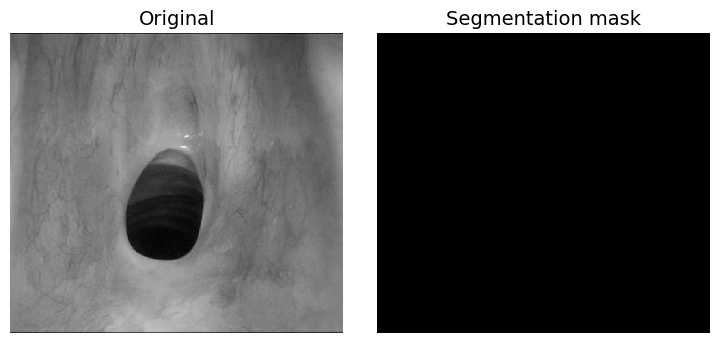

In [65]:
i_example = 3

fig, AX = plt.subplots(1, 2, figsize=(7, 3))
plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0.1)

for ax in AX:
    ax = ax_decorate_box(ax)
    
AX[0].pcolormesh(np.mean(input_example[i_example, ...], axis=-1), cmap=plt.cm.gray)
AX[1].pcolormesh(np.mean(label_example[i_example, ...], axis=-1), cmap=plt.cm.gray)
#AX[1].pcolormesh(label_example[i_example, ..., 0]>0, cmap=plt.cm.gray)
AX[0].set_title("Original", fontsize=14);
AX[1].set_title("Segmentation mask", fontsize=14);

## Attention U-net with an ImageNet-trained backbone

Attention U-net is applied for this segmentation task. This architecture is modified from the conventionally used U-net by assigning attention gates on each upsampling level. 

Attention gates take upsampled (i.e., decoded) and downsampled (i.e., encoded) tensors as queries and keys, respectively. These queries and keys are mapped to intermediate channel sizes and fed into the additive attention learning. The resulting vector is rescaled by a sigmoid function and multiplied with the downsampled tensor (keys, but here treated as "values" of self-attention). The attention gate output replaces the downsampled tensor and is concatenated with the upsampled tensor.

Based on the amount and complexity of COCO samples, ImageNet-trained VGG16 is applied as an encoder backbone. This transfer learning strategy is expected to improve the segmentation performance based on two reasons: 

 * The ImageNet and COCO containts (somewhat) similar kinds of natural images with a high overlap of data distribution; 

 * The VGG16 architecture is a combination of same-padding convolution and max-pooling kernels, capable of extracting hierarchical features that can be processed by attention gates (ResNet backbone contains zero padding layers and is suboptimal in this case).

The code cell below configures the attention U-net with an ImageNet-trained VGG16 backbone. Hyper-parameters are explained through the Python helper function:

```python
from keras_unet_collection import models

help(models.att_unet_2d)
```

In [59]:
model = models.att_unet_2d((512, 512, 3), filter_num=[64, 128, 256, 512, 1024], n_labels=2, 
                           stack_num_down=2, stack_num_up=2, activation='ReLU', 
                           atten_activation='ReLU', attention='add', output_activation='Sigmoid', 
                           batch_norm=True, pool=False, unpool=False, 
                           backbone='VGG16', weights='imagenet', 
                           freeze_backbone=True, freeze_batch_norm=True, 
                           name='attunet')

C:\Users\pinksterbha\OneDrive - UMCG\Studie\SGGS\code\MLLab\keras_unet_collection\_backbone_zoo.py:45: UserWarning: 

Backbone VGG16 does not use batch norm, but other layers received batch_norm=True
  warnings.warn(param_mismatch);


The second layer of the configured model, i.e., right after an input layer, is expected to be the VGG16 backbone.

In [22]:
model.layers[1].name

'VGG16_backbone'

For simplicity, this segmentation model is trained with cross-entropy loss with SGD optimizer and a learning rate of 1E-2.

In [23]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.SGD(learning_rate=1e-2))

## Training

The segmentation model is trained with 200 epoches with early stopping. Each epoch containts 100 batches and each batch contains 32 samples.

*The training process here is far from systematic, and is provided for illustration purposes only.*

In [24]:
def input_data_process(input_array):
    '''converting pixel vales to [0, 1]'''
    return input_array/255.

def target_data_process(target_array):
    '''Converting human, non-human pixels into two categories.'''
    target_array[target_array>0]=1 # grouping all other non-human categories 
    return keras.utils.to_categorical(target_array, num_classes=2)

In [62]:
valid_input = input_data_process(utils.image_to_array(valid_names, size=512, channel=3))
valid_label = target_data_process(utils.image_to_array(valid_labels, size=512, channel=3))

In [ ]:
N_epoch = 200 # number of epoches
N_batch = 100 # number of batches per epoch
N_sample = 32 # number of samples per batch

tol = 0 # current early stopping patience
max_tol = 2 # the max-allowed early stopping patience
min_del = 0 # the lowest acceptable loss value reduction 

# loop over epoches
for epoch in range(N_epoch):    
    # initial loss record
    if epoch == 0:
        y_pred = model.predict([valid_input])
        record = np.mean(keras.losses.categorical_crossentropy(valid_label, y_pred))
        print('\tInitial loss = {}'.format(record))
    
    # loop over batches
    for step in range(N_batch):
        # selecting smaples for the current batch
        ind_train_shuffle = utils.shuffle_ind(L_train)[:N_sample]
        
        # batch data formation
        ## augmentation is not applied
        train_input = input_data_process(utils.image_to_array(train_names[ind_train_shuffle], size=512, channel=3))
        train_label = target_data_process(utils.image_to_array(train_labels[ind_train_shuffle], size=512, channel=3))
        
        # train on batch
        loss_ = model.train_on_batch([train_input,], [train_label,])
        # ** training loss is not stored ** #
        
    # epoch-end validation
    y_pred = model.predict([valid_input])
    record_temp = np.mean(keras.losses.categorical_crossentropy(valid_label, y_pred))
    # ** validation loss is not stored ** #
    
    # if loss is reduced
    if record - record_temp > min_del:
        print('Validation performance is improved from {} to {}'.format(record, record_temp))
        record = record_temp; # update the loss record
        tol = 0; # refresh early stopping patience
        # ** model checkpoint is not stored ** #
        
    # if loss not reduced
    else:
        print('Validation performance {} is NOT improved'.format(record_temp))
        tol += 1
        if tol >= max_tol:
            print('Early stopping')
            break;
        else:
            # Pass to the next epoch
            continue;

## Evaluation

The testing set performance is evaluated with cross-entropy and example outputs.

In [ ]:
test_input = input_data_process(utils.image_to_array(test_names, size=512, channel=3))
test_label = target_data_process(utils.image_to_array(test_labels, size=512, channel=3))

In [ ]:
y_pred = model.predict([test_input])

In [ ]:
print('Testing set cross-entropy = {}'.format(np.mean(keras.losses.categorical_crossentropy(test_label, y_pred))))

**Example of outputs**

As a common practice in computer vision projects, only nice looking samples are plotted : |

In [ ]:
i_sample = 12

fig, AX = plt.subplots(1, 3, figsize=(13, (13-0.2)/3))
plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0.1)
for ax in AX:
    ax = ax_decorate_box(ax)
AX[0].pcolormesh(np.mean(test_input[i_sample, ...,], axis=-1), cmap=plt.cm.gray)
AX[1].pcolormesh(y_pred[i_sample, ..., 0], cmap=plt.cm.jet)
AX[2].pcolormesh(test_label[i_sample, ..., 0], cmap=plt.cm.jet)

AX[0].set_title("Original", fontsize=14);
AX[1].set_title("Pixels belong to human (red for high probabilities)", fontsize=14);
AX[2].set_title("Labeled truth", fontsize=14);


## Discussion

A segmentation model is proposed based on the architecture of UNET 3+ and is trained using the Oxford-IIIT Pets dataset. Result evaluation indicates that this segmentation model can distinguish pixes of a pet from image backgrounds.

Many technical details of this work, for example, network hyper-parameters and training strategy, can be improved for achieving better performance. 